<a href="https://colab.research.google.com/github/indrajitt/gMLPs-Image-Classification/blob/main/gMLPs_for_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using gMLPs for Image Classification

This notebook explores the using simple's MLPs with gating as an alternative to vision transformers for image classification. The notebook is based on this paper:

*Hanxiao Liu, Zihang Dai, David R. So, Quoc V. Le (Jun 2021). [Pay Attention to MLPs](https://arxiv.org/abs/2105.08050v2). arXiv:2105.08050 [cs.LG]*

## Setup

In [1]:
!pip install einops

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import shutil


from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce
from torch import nn, optim
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm

# SEED
torch.manual_seed(0)

In [3]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla K80


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Utility functions
def pair(val):
  return (val, val) if not isinstance(val, tuple) else val

def exists(val):
  return val is not None

def dropout_layers(layers, prob_survival):
  if prob_survival == 1:
    return layers

  num_layers = len(layers)
  to_drop = torch.zeros(num_layers).uniform_(0., 1.) > prob_survival

  # make sure at least one layer makes it
  if all(to_drop):
    rand_index = randrange(num_layers)
    to_drop[rand_index] = False

  layers = [layer for (layer, drop) in zip(layers, to_drop) if not drop]
  return layers

def check_size(image_size, patch_size):
  sqrt_num_patches, remainder = divmod(image_size, patch_size)
  assert remainder == 0, "`image_size` must be divisibe by `patch_size`"
  num_patches = sqrt_num_patches ** 2
  return num_patches


## Understanding the model

The transformer architecture combines two important concepts:  


1. A recurrent-free architecture
which computes the representations for each individual token in parallel  
multi-head self attention.
2.   Blocks which aggregate spatial information across tokens.  

This model is basically a MLP-based alternative to Transformers without self-attention. It consists of spatial and channel projections with static parameterization.  
***
 To investigate the necessity of the Transformer's self-attention mechanism, the team designed gMLP using only basic MLP layers combined with gating, then compared its performance on vision and language tasks to previous Transformer implementations.On the ImageNet image classification task, gMLP achieves an accuracy of 81.6, comparable to Vision Transformers (ViT) at 81.8, while using fewer parameters and FLOPs.

***
We will now explore the model propsed by the researchers:


### Spatial Gating Unit
The main innovation in gMLP is a Spatial Gating Unit (SGU) which captures the interactions across sequence elements; this performs the same role as attention in a Transformer, but without requiring encodings for element positions. Instead, the SGU performs element-wise multiplication of its input with a linear projection of that same input. The researchers found that for training stability, it was necessary to initialize the weights of the gate to 1, which in effect makes the gate a simple pass-through; in the course of training, the weights are updated to learn the spatial interactions between sequence elements. The image below shows the structure of the spatial gating unit : 

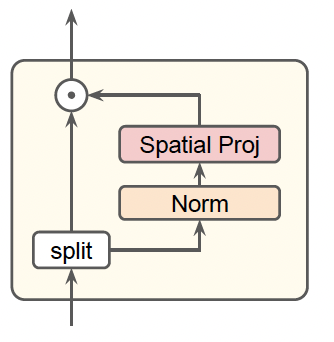

In [6]:
class SpatialGatingUnit(nn.Module):
    def __init__(self, d_ffn, seq_len):
        super().__init__()
        self.norm = nn.LayerNorm(d_ffn)
        self.spatial_proj = nn.Conv1d(seq_len, seq_len, kernel_size=1)
        nn.init.constant_(self.spatial_proj.bias, 1.0)

    def forward(self, x):
        u, v = x.chunk(2, dim=-1)
        v = self.norm(v)
        v = self.spatial_proj(v)
        out = u * v
        return out

### GMLP Block

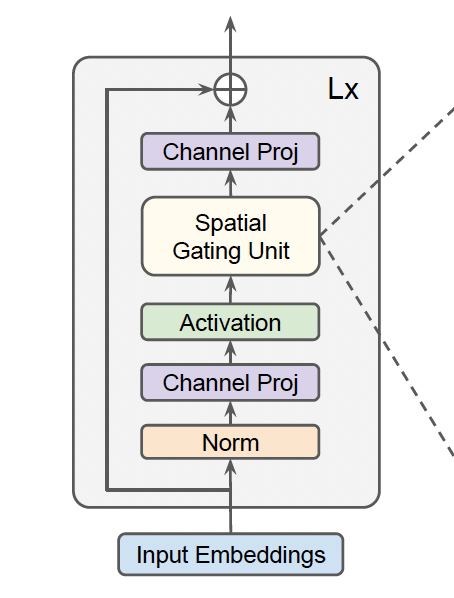


In [7]:
class gMLPBlock(nn.Module):
    def __init__(self, d_model, d_ffn, seq_len):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.channel_proj1 = nn.Linear(d_model, d_ffn * 2)
        self.gelu_activation = nn.GELU()
        self.channel_proj2 = nn.Linear(d_ffn, d_model)
        self.sgu = SpatialGatingUnit(d_ffn, seq_len)

    def forward(self, x):
        residual = x
        x = self.norm(x)
        x = self.channel_proj1(x)
        x = self.gelu_activation(x)
        x = self.sgu(x)
        x = self.channel_proj2(x)
        out = x + residual
        return out

In [8]:

class gMLP(nn.Module):
    def __init__(self, d_model=256, d_ffn=512, seq_len=256, num_layers=6):
        super().__init__()
        self.model = nn.Sequential(
            *[gMLPBlock(d_model, d_ffn, seq_len) for _ in range(num_layers)]
        )

    def forward(self, x):
        return self.model(x)

In [9]:
class gMLPForImageClassification(gMLP):
    def __init__(
        self,
        image_size=256,
        patch_size=16,
        in_channels=3,
        num_classes=1000,
        d_model=256,
        d_ffn=512,
        seq_len=256,
        num_layers=6,
    ):
        num_patches = check_size(image_size, patch_size)
        super().__init__(d_model, d_ffn, seq_len, num_layers)
        self.patcher = nn.Conv2d(
            in_channels, d_model, kernel_size=patch_size, stride=patch_size
        )
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        patches = self.patcher(x)
        batch_size, num_channels, _, _ = patches.shape
        patches = patches.permute(0, 2, 3, 1)
        patches = patches.view(batch_size, -1, num_channels)
        embedding = self.model(patches)
        embedding = embedding.mean(dim=1)
        out = self.classifier(embedding)
        return out

## Preparation of dataset for training and evaluation

We chose the CIFAR-10 dataset for the purpose of this Image Classification task. The CIFAR-10 dataset is a standard **balanced dataset** used for several image classification tasks like ImageNet which is used in the paper. The limitations of this dataset is that it consists of a **lesser number of images that are of lower resolution than the images that were used in this paper**. However it is an appropraite dataset for image classification taking into consideration the amount of compute resources that are available to us.

In [10]:
def CIFAR10DataLoader(split, batch_size=8, num_workers=2, shuffle=True):
    '''
    A wrapper function that creates a DataLoader for CIFAR10 dataset loaded from torchvision using 
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
    Output:
        DataLoader Object
    '''
    mean = [0.5, 0.5, 0.5]
    std =  [0.5, 0.5, 0.5]
    if split == 'train':
      train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
      cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
      dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    elif split == 'test':
      test_transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
      ])
      cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
      dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader

In [11]:
train_dataloader = CIFAR10DataLoader('train')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

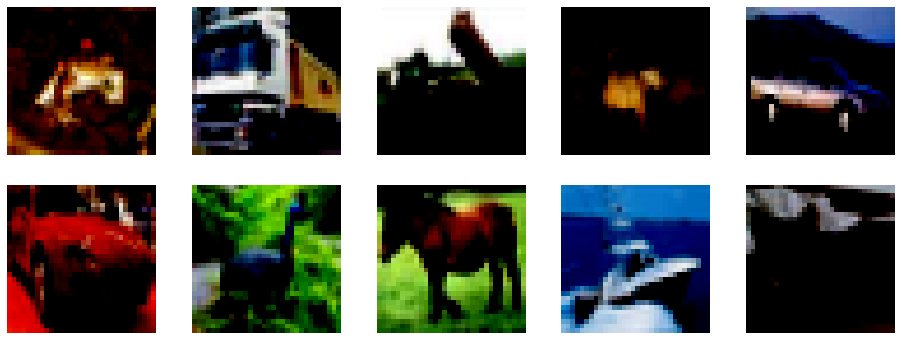

In [12]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_dataloader.dataset.__getitem__(i)
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')

## Model training and evaluation

In [13]:
# Initializations of all the constants used in the training and testing process
lr = 0.003
batch_size = 128
num_workers = 2
patch_size = 4
classes = 10
channels = 3
epochs = 75

In [14]:
def train(model, dataloader, criterion, optimizer):
    '''
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    '''
    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to("cuda")
        target = target.to("cuda")
        output = model(data)
        
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

def evaluation(model, dataloader, criterion):
    '''
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    '''
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)
            output = model(data)
      
            loss = criterion(output, target)
            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy

In [15]:
model = gMLPForImageClassification(image_size = 32,
      patch_size = patch_size,
      in_channels = channels,
      num_classes = classes,
      d_model=128,
      d_ffn=256,
      seq_len=64,
      num_layers=6)
model = model.cuda()
model.name = "gMLP"
summary(model, (3, 32, 32), 128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 128, 8, 8]           6,272
         LayerNorm-2             [128, 64, 128]             256
            Linear-3             [128, 64, 512]          66,048
              GELU-4             [128, 64, 512]               0
         LayerNorm-5             [128, 64, 256]             512
            Conv1d-6             [128, 64, 256]           4,160
 SpatialGatingUnit-7             [128, 64, 256]               0
            Linear-8             [128, 64, 128]          32,896
         gMLPBlock-9             [128, 64, 128]               0
        LayerNorm-10             [128, 64, 128]             256
           Linear-11             [128, 64, 512]          66,048
             GELU-12             [128, 64, 512]               0
        LayerNorm-13             [128, 64, 256]             512
           Conv1d-14             [128, 

In [16]:
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
def run_model(epochs, model, resume_from_checkpoint=False):
  """
      This function takes the model as an argument and runs the model for the 
    specified number of epochs. The user can choose to resume from the epoch, 
    saved in gDrive.

    Args:
          model: Model supplied to the function
          epochs: Number of epochs to run the model for
          resume_from_checkpoint: Used saved parameters to resume training from 
            last epoch (Default = False)
    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
  """
  train_accs = []
  test_accs = []

  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

  if not resume_from_checkpoint:
    for epoch in range(epochs):

        running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer)
        print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
        train_accs.append(running_accuracy)

        test_loss, test_accuracy = evaluation(model, test_dataloader, criterion)
        print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
        test_accs.append(test_accuracy)

        if (epoch+1)%5 == 0:
          torch.save({
                'epoch': epoch,
                'model': model,
                'optimizer': optimizer,
                'scheduler': scheduler,
                'train_acc': train_accs,
                'test_acc': test_accs
            }, './drive/MyDrive/ModelParameters/' + model.name + '_CIFAR10_checkpoint.pt') 
  else: 
  # Resume from saved epoch
    checkpoint = torch.load('./drive/MyDrive/ModelParameters/' + model.name + '_CIFAR10_checkpoint.pt')
    model = checkpoint['model']
    last_epoch = checkpoint['epoch']
    optimizer = checkpoint['optimizer']
    schdeuler = checkpoint['scheduler']
    train_accs = checkpoint['train_acc']
    test_accs = checkpoint['test_acc']
    print("Resuming from epoch : "+str(last_epoch))
    for epoch in range(last_epoch+1, epochs):

        running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer)
        print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
        train_accs.append(running_accuracy)

        test_loss, test_accuracy = evaluation(model, test_dataloader, criterion)
        print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
        test_accs.append(test_accuracy)

        if (epoch+1)%5 == 0:
          torch.save({
                'epoch': epoch,
                'model': model,
                'optimizer': optimizer,
                'scheduler': scheduler,
                'train_acc': train_accs,
                'test_acc': test_accs
            }, './drive/MyDrive/ModelParameters/' + model.name + '_CIFAR10_checkpoint.pt') 
  return train_accs, test_accs

In [18]:
def print_performance_graph(epochs, model_name, train_accs, test_accs):
  train_accs_cpu = [acc.cpu().item() for acc in train_accs]
  test_accs_cpu = [acc.cpu().item() for acc in test_accs]

  plt.style.use('seaborn')
  plt.plot(range(1, epochs+1), train_accs_cpu, label='Train Accuracy')
  plt.plot(range(1, epochs+1), test_accs_cpu, label='Test Accuracy')

  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")

  plt.title("Train vs Test Accuracy for "+model_name)
  plt.legend(loc='lower right')

In [19]:
train_accs, test_accs = run_model(epochs, model, True)

Resuming from epoch : 74


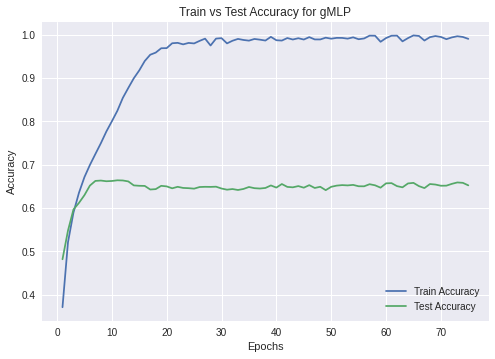

In [20]:
print_performance_graph(epochs, "gMLP", train_accs, test_accs)

## Comparison with ViT

Vision Transformer is currently considered to be one of the best models available for Image Classifaction tasks. The sequence of the operations is as follows -

    Input -> CreatePatches -> ClassToken, PatchToEmbed , PositionEmbed -> Transformer -> ClassificationHead -> Output
                                   |            | |                |
                                   |---Concat---| |----Addition----|

We now implement a ViT model from scratch and train it on the same data. We use the performance of ViT on the same dataset after training with same compute power to compare the performance of ViT against gMLP. To implement the model from scratch, [this](https://github.com/ra1ph2/Vision-Transformer) repo was used a a reference.



In [21]:
class Attention(nn.Module):
  def __init__(self, embed_dim, heads=8, activation=None, dropout=None):
    super(Attention, self).__init__()
    self.heads = heads
    self.embed_dim = embed_dim
    
    self.queries = nn.Linear(embed_dim, embed_dim, bias=False)
    self.keys = nn.Linear(embed_dim, embed_dim, bias=False)
    self.values = nn.Linear(embed_dim, embed_dim, bias=False)

    if activation == "relu":
      self.activation = nn.ReLU()
    else:
      self.activation = nn.Identity()
    self.dropout = nn.Dropout(dropout)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, input):
    # input.size = (batch_size, seq_len, embed_dim)
    batch_size, seq_len, embed_dim = input.size()
    assert embed_dim == self.embed_dim, "Received input does not have expected\
 embedding dimension"

    queries = self.activation(self.queries(input))  
    keys = self.activation(self.keys(input))  
    values =self.activation(self.values(input))  

    # output : (batch_size * heads, seq_len, reduced_dim)
    queries = self._reshape_heads(queries)  
    keys = self._reshape_heads(keys)  
    values =self._reshape_heads(values) 

    # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
    attention_scores = self.softmax(torch.matmul(queries, keys.transpose(1, 2))) 

    # out: (batch_size * heads, seq_len, reduced_dim)
    out = torch.matmul(self.dropout(attention_scores), values)
    
    # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
    out = self._reshape_heads_back(out)

    return out, attention_scores

  def _reshape_heads(self, inp):
    # inp: (batch_size, seq_len, embed_dim)
    batch_size, seq_len, embed_dim = inp.size()

    reduced_dim = self.embed_dim // self.heads
    assert reduced_dim * self.heads == self.embed_dim
    out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
    out = out.permute(0, 2, 1, 3)
    out = out.reshape(-1, seq_len, reduced_dim)

    # out: (batch_size * heads, seq_len, reduced_dim)
    return out

  def _reshape_heads_back(self, inp):
    # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
    batch_size_mul_heads, seq_len, reduced_dim = inp.size()
    batch_size = batch_size_mul_heads // self.heads

    out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
    out = out.permute(0, 2, 1, 3)
    out = out.reshape(batch_size, seq_len, self.embed_dim)

    # out: (batch_size, seq_len, embed_dim)
    return out


In [22]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out 

In [23]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res
        
        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

In [24]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

In [25]:
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes) 
        return out

In [26]:
class VisionTransformer(nn.Module):
    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()
        
        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim) 
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)
        
        return class_out

In [27]:
# Vision Transformer Architecture
epochs = 50
model = VisionTransformer(
    patch_size=patch_size,
    max_len=100,
    embed_dim=512,
    classes=classes,
    layers=12,
    channels=channels,
    heads=8).to(device)

summary(model, (3, 32, 32), 128)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [128, 64, 512]          25,088
         LayerNorm-2             [128, 65, 512]           1,024
            Linear-3             [128, 65, 512]         262,144
          Identity-4             [128, 65, 512]               0
            Linear-5             [128, 65, 512]         262,144
          Identity-6             [128, 65, 512]               0
            Linear-7             [128, 65, 512]         262,144
          Identity-8             [128, 65, 512]               0
           Softmax-9              [128, 65, 65]               0
          Dropout-10              [128, 65, 65]               0
        Attention-11  [[-1, 65, 512], [-1, 65, 65]]               0
        LayerNorm-12             [128, 65, 512]           1,024
           Linear-13             [128, 65, 512]         262,656
             GELU-14             [1

In [28]:
train_accs, test_accs = run_model(epochs, model, True)

Resuming from epoch : 49


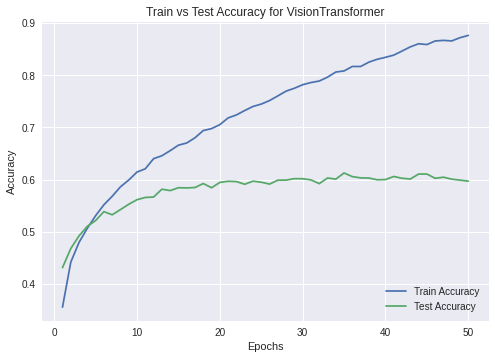

In [29]:
print_performance_graph(epochs, model.name, train_accs, test_accs)

## Ablation Study :gMLP with Self-Attention

In the paper "*Pay Attention to MLPs*" the authors perform an ablation study on the usefulness of attention for NLP tasks. For our study we will be performing a similar study on the effectiveness of self-attention for Image Classification tasks using [this](https://github.com/lucidrains/g-mlp-pytorch) repo as a reference.

To isolate the effect of self-attention, we experiment with a hybrid model where a tiny self-attention
block is attached to the gating function of gMLP. gMLP itself is capable of capturing spatial relationships, the authors hypothesize that this extra self-attention module's presence is more relevant than its capacity. In our model we use a small attention head which has size 64. This is much lesser in comparision to transformer models like ViT which usually have 8 heads with larger size. 

In [30]:
class Attention(nn.Module):
  def __init__(self, dim_in, dim_out, dim_inner):
    super().__init__()
    self.scale = dim_inner ** -0.5

    self.to_qkv = nn.Linear(dim_in, dim_inner * 3, bias = False)
    self.to_out = nn.Linear(dim_inner, dim_out)

  def forward(self, x):
    q, k, v = self.to_qkv(x).chunk(3, dim = -1)
    sim = torch.einsum('b i d, b j d -> b i j', q, k) * self.scale

    attn = sim.softmax(dim = -1)
    out = torch.einsum('b i j, b j d -> b i d', attn, v)
    return self.to_out(out)

In [31]:
class SpatialGatingUnit(nn.Module):
  def __init__(
      self,
      dim,
      dim_seq,
      act = nn.Identity(),
      heads = 1,
      init_eps = 1e-3
  ):

    super().__init__()
    dim_out = dim // 2
    self.heads = heads
    self.norm = nn.LayerNorm(dim_out)

    self.act = act

    shape = (heads, dim_seq, dim_seq)
    weight = torch.zeros(shape).to(device)

    self.weight = nn.Parameter(weight)
    init_eps /= dim_seq
    nn.init.uniform_(self.weight, -init_eps, init_eps)

    self.bias = nn.Parameter(torch.ones(heads, dim_seq).to(device))

  def forward(self, x, gate_res = None):
    n, h = x.shape[1], self.heads

    res, gate = x.chunk(2, dim = -1)
    gate = self.norm(gate)

    weight, bias = self.weight, self.bias

    gate = rearrange(gate, 'b n (h d) -> b h n d', h = h)

    gate = torch.einsum('b h n d, h m n -> b h m d', gate, weight)
    gate = gate + rearrange(bias, 'h n -> () h n ()')

    gate = rearrange(gate, 'b h n d -> b n (h d)')

    if exists(gate_res):
      gate = gate + gate_res

    return self.act(gate) * res

In [32]:
class gMLPBlock(nn.Module):
  def __init__(
      self,
      *,
      dim,
      dim_ff,
      seq_len,
      heads = 1,
      attn_dim = None,
      act = nn.Identity()
  ):
    super().__init__()
    self.proj_in = nn.Sequential(
        nn.Linear(dim, dim_ff),
        nn.GELU()
    )

    self.attn = Attention(dim, dim_ff // 2, attn_dim) if exists(attn_dim) else None

    self.sgu = SpatialGatingUnit(dim_ff, seq_len, act, heads)
    self.proj_out = nn.Linear(dim_ff // 2, dim)

  def forward(self, x):
    gate_res = self.attn(x) if exists(self.attn) else None
    x = self.proj_in(x)
    x = self.sgu(x, gate_res = gate_res)
    x = self.proj_out(x)
    return x

In [33]:
class Residual(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x):
    return self.fn(x) + x

In [34]:
class PreNorm(nn.Module):
  def __init__(self, dim, fn):
    super().__init__()
    self.fn = fn
    self.norm = nn.LayerNorm(dim)

  def forward(self, x, **kwargs):
    x = self.norm(x)
    return self.fn(x, **kwargs)

In [35]:
class gMLPVision(nn.Module):
  def __init__(
      self,
      *,
      image_size,
      patch_size,
      num_classes,
      dim,
      depth,
      heads = 1,
      ff_mult = 4,
      channels = 3,
      attn_dim = None,
      prob_survival = 1.
  ):
    super().__init__()
    self.name = "gMLP_w_self_attention"
    assert (dim % heads) == 0, 'dimension must be divisible by number of heads'

    image_height, image_width = pair(image_size)
    patch_height, patch_width = pair(patch_size)
    assert (image_height % patch_height) == 0 and (image_width % patch_width) == 0, 'image height and width must be divisible by patch size'
    num_patches = (image_height // patch_height) * (image_width // patch_width)

    dim_ff = dim * ff_mult

    self.to_patch_embed = nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (c p1 p2)', p1 = patch_height, p2 = patch_width),
        nn.Linear(channels * patch_height * patch_width, dim)
    )

    self.prob_survival = prob_survival

    self.layers = nn.ModuleList([Residual(PreNorm(dim, gMLPBlock(dim = dim, heads = heads, dim_ff = dim_ff, seq_len = num_patches, attn_dim = attn_dim))) for i in range(depth)])

    self.to_logits = nn.Sequential(
        nn.LayerNorm(dim),
        Reduce('b n d -> b d', 'mean'),
        nn.Linear(dim, num_classes)
    )

  def forward(self, x):
    x = self.to_patch_embed(x)
    layers = self.layers if not self.training else dropout_layers(self.layers, self.prob_survival)
    x = nn.Sequential(*layers)(x)
    return self.to_logits(x)



In [36]:
model = gMLPVision(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 256,
    depth = 6,
    attn_dim = 1
)
model = model.cuda()
epochs = 25
model.name = "gMLP_w_self_attention"
summary(model, (3, 32, 32), 128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1              [128, 64, 48]               0
            Linear-2             [128, 64, 256]          12,544
         LayerNorm-3             [128, 64, 256]             512
            Linear-4               [128, 64, 3]             768
            Linear-5             [128, 64, 512]           1,024
         Attention-6             [128, 64, 512]               0
            Linear-7            [128, 64, 1024]         263,168
              GELU-8            [128, 64, 1024]               0
         LayerNorm-9             [128, 64, 512]           1,024
         Identity-10             [128, 64, 512]               0
         Identity-11             [128, 64, 512]               0
         Identity-12             [128, 64, 512]               0
         Identity-13             [128, 64, 512]               0
         Identity-14             [128, 

In [37]:
train_accs, test_accs = run_model(epochs, model, True)

100%|██████████| 391/391 [01:38<00:00,  3.95it/s]


Epoch : 1 - acc: 0.4182 - loss : 1.5917



100%|██████████| 79/79 [00:08<00:00,  9.44it/s]


test acc: 0.5307 - test loss : 1.2741



100%|██████████| 391/391 [01:39<00:00,  3.94it/s]


Epoch : 2 - acc: 0.5840 - loss : 1.1568



100%|██████████| 79/79 [00:08<00:00,  9.43it/s]


test acc: 0.6011 - test loss : 1.0915



100%|██████████| 391/391 [01:38<00:00,  3.96it/s]


Epoch : 3 - acc: 0.6557 - loss : 0.9639



100%|██████████| 79/79 [00:08<00:00,  9.49it/s]


test acc: 0.6567 - test loss : 0.9604



100%|██████████| 391/391 [01:38<00:00,  3.96it/s]


Epoch : 4 - acc: 0.6992 - loss : 0.8449



100%|██████████| 79/79 [00:08<00:00,  9.47it/s]


test acc: 0.6862 - test loss : 0.8940



100%|██████████| 391/391 [01:38<00:00,  3.96it/s]


Epoch : 5 - acc: 0.7414 - loss : 0.7336



100%|██████████| 79/79 [00:08<00:00,  9.48it/s]


test acc: 0.7010 - test loss : 0.8495



100%|██████████| 391/391 [01:39<00:00,  3.94it/s]


Epoch : 6 - acc: 0.7748 - loss : 0.6374



100%|██████████| 79/79 [00:08<00:00,  9.50it/s]


test acc: 0.7123 - test loss : 0.8295



100%|██████████| 391/391 [01:38<00:00,  3.96it/s]


Epoch : 7 - acc: 0.8072 - loss : 0.5430



100%|██████████| 79/79 [00:08<00:00,  9.51it/s]


test acc: 0.7081 - test loss : 0.8559



100%|██████████| 391/391 [01:38<00:00,  3.96it/s]


Epoch : 8 - acc: 0.8435 - loss : 0.4487



100%|██████████| 79/79 [00:08<00:00,  9.41it/s]


test acc: 0.7143 - test loss : 0.8575



100%|██████████| 391/391 [01:38<00:00,  3.96it/s]


Epoch : 9 - acc: 0.8754 - loss : 0.3582



100%|██████████| 79/79 [00:08<00:00,  9.51it/s]


test acc: 0.7163 - test loss : 0.9040



100%|██████████| 391/391 [01:39<00:00,  3.94it/s]


Epoch : 10 - acc: 0.9095 - loss : 0.2675



100%|██████████| 79/79 [00:08<00:00,  9.39it/s]


test acc: 0.7055 - test loss : 1.0036



100%|██████████| 391/391 [01:39<00:00,  3.94it/s]


Epoch : 11 - acc: 0.9352 - loss : 0.1904



100%|██████████| 79/79 [00:08<00:00,  9.33it/s]


test acc: 0.7094 - test loss : 1.1008



100%|██████████| 391/391 [01:39<00:00,  3.94it/s]


Epoch : 12 - acc: 0.9532 - loss : 0.1395



100%|██████████| 79/79 [00:08<00:00,  9.37it/s]


test acc: 0.7113 - test loss : 1.1693



100%|██████████| 391/391 [01:39<00:00,  3.94it/s]


Epoch : 13 - acc: 0.9647 - loss : 0.1067



100%|██████████| 79/79 [00:08<00:00,  9.33it/s]


test acc: 0.7123 - test loss : 1.2783



100%|██████████| 391/391 [01:39<00:00,  3.93it/s]


Epoch : 14 - acc: 0.9759 - loss : 0.0738



100%|██████████| 79/79 [00:08<00:00,  9.35it/s]


test acc: 0.7032 - test loss : 1.3734



100%|██████████| 391/391 [01:39<00:00,  3.94it/s]


Epoch : 15 - acc: 0.9779 - loss : 0.0657



100%|██████████| 79/79 [00:08<00:00,  9.31it/s]


test acc: 0.7086 - test loss : 1.4307



100%|██████████| 391/391 [01:39<00:00,  3.94it/s]


Epoch : 16 - acc: 0.9753 - loss : 0.0730



100%|██████████| 79/79 [00:08<00:00,  9.33it/s]


test acc: 0.7023 - test loss : 1.4776



100%|██████████| 391/391 [01:39<00:00,  3.94it/s]


Epoch : 17 - acc: 0.9813 - loss : 0.0578



100%|██████████| 79/79 [00:08<00:00,  9.32it/s]


test acc: 0.7123 - test loss : 1.4932



100%|██████████| 391/391 [01:39<00:00,  3.92it/s]


Epoch : 18 - acc: 0.9869 - loss : 0.0389



100%|██████████| 79/79 [00:08<00:00,  9.35it/s]


test acc: 0.7062 - test loss : 1.5828



100%|██████████| 391/391 [01:39<00:00,  3.93it/s]


Epoch : 19 - acc: 0.9858 - loss : 0.0430



100%|██████████| 79/79 [00:08<00:00,  9.30it/s]


test acc: 0.7084 - test loss : 1.5803



100%|██████████| 391/391 [01:39<00:00,  3.95it/s]


Epoch : 20 - acc: 0.9818 - loss : 0.0542



100%|██████████| 79/79 [00:08<00:00,  9.44it/s]


test acc: 0.7109 - test loss : 1.5949



100%|██████████| 391/391 [01:39<00:00,  3.94it/s]


Epoch : 21 - acc: 0.9873 - loss : 0.0373



100%|██████████| 79/79 [00:08<00:00,  9.36it/s]


test acc: 0.7081 - test loss : 1.6499



100%|██████████| 391/391 [01:39<00:00,  3.93it/s]


Epoch : 22 - acc: 0.9875 - loss : 0.0376



100%|██████████| 79/79 [00:08<00:00,  9.36it/s]


test acc: 0.7091 - test loss : 1.6783



100%|██████████| 391/391 [01:38<00:00,  3.95it/s]


Epoch : 23 - acc: 0.9863 - loss : 0.0417



100%|██████████| 79/79 [00:08<00:00,  9.39it/s]


test acc: 0.7072 - test loss : 1.6821



100%|██████████| 391/391 [01:39<00:00,  3.95it/s]


Epoch : 24 - acc: 0.9851 - loss : 0.0434



100%|██████████| 79/79 [00:08<00:00,  9.34it/s]


test acc: 0.7081 - test loss : 1.6501



100%|██████████| 391/391 [01:39<00:00,  3.95it/s]


Epoch : 25 - acc: 0.9908 - loss : 0.0281



100%|██████████| 79/79 [00:08<00:00,  9.40it/s]


test acc: 0.7085 - test loss : 1.7369



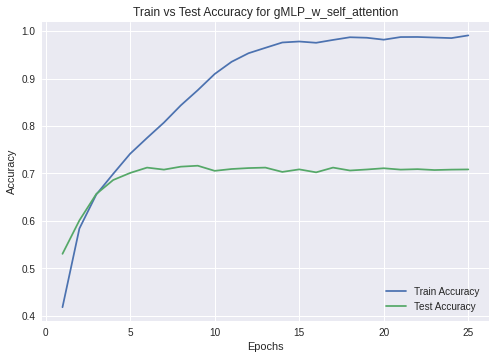

In [38]:
print_performance_graph(epochs, model.name, train_accs, test_accs)

In [39]:
model = gMLPVision(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 256,
    depth = 6,
    attn_dim = 64
)
model = model.cuda()
epochs = 25
model.name = "gMLP_w_self_attention_64"
summary(model, (3, 32, 32), 128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1              [128, 64, 48]               0
            Linear-2             [128, 64, 256]          12,544
         LayerNorm-3             [128, 64, 256]             512
            Linear-4             [128, 64, 192]          49,152
            Linear-5             [128, 64, 512]          33,280
         Attention-6             [128, 64, 512]               0
            Linear-7            [128, 64, 1024]         263,168
              GELU-8            [128, 64, 1024]               0
         LayerNorm-9             [128, 64, 512]           1,024
         Identity-10             [128, 64, 512]               0
         Identity-11             [128, 64, 512]               0
         Identity-12             [128, 64, 512]               0
         Identity-13             [128, 64, 512]               0
         Identity-14             [128, 

In [40]:
train_accs, test_accs = run_model(epochs, model, False)

100%|██████████| 391/391 [01:49<00:00,  3.58it/s]


Epoch : 1 - acc: 0.4184 - loss : 1.5880



100%|██████████| 79/79 [00:08<00:00,  8.81it/s]


test acc: 0.5279 - test loss : 1.2915



100%|██████████| 391/391 [01:50<00:00,  3.55it/s]


Epoch : 2 - acc: 0.5824 - loss : 1.1590



100%|██████████| 79/79 [00:08<00:00,  8.81it/s]


test acc: 0.6107 - test loss : 1.0606



100%|██████████| 391/391 [01:49<00:00,  3.58it/s]


Epoch : 3 - acc: 0.6616 - loss : 0.9456



100%|██████████| 79/79 [00:08<00:00,  8.91it/s]


test acc: 0.6567 - test loss : 0.9540



100%|██████████| 391/391 [01:49<00:00,  3.58it/s]


Epoch : 4 - acc: 0.7155 - loss : 0.8041



100%|██████████| 79/79 [00:08<00:00,  8.90it/s]


test acc: 0.6855 - test loss : 0.8760



100%|██████████| 391/391 [01:48<00:00,  3.60it/s]


Epoch : 5 - acc: 0.7543 - loss : 0.6913



100%|██████████| 79/79 [00:08<00:00,  8.88it/s]


test acc: 0.6930 - test loss : 0.8552



100%|██████████| 391/391 [01:48<00:00,  3.59it/s]


Epoch : 6 - acc: 0.7925 - loss : 0.5890



100%|██████████| 79/79 [00:08<00:00,  8.92it/s]


test acc: 0.7187 - test loss : 0.8131



100%|██████████| 391/391 [01:48<00:00,  3.60it/s]


Epoch : 7 - acc: 0.8327 - loss : 0.4763



100%|██████████| 79/79 [00:08<00:00,  8.87it/s]


test acc: 0.7139 - test loss : 0.8520



100%|██████████| 391/391 [01:48<00:00,  3.61it/s]


Epoch : 8 - acc: 0.8735 - loss : 0.3630



100%|██████████| 79/79 [00:08<00:00,  8.92it/s]


test acc: 0.7106 - test loss : 0.9048



100%|██████████| 391/391 [01:48<00:00,  3.61it/s]


Epoch : 9 - acc: 0.9100 - loss : 0.2643



100%|██████████| 79/79 [00:08<00:00,  8.92it/s]


test acc: 0.7099 - test loss : 1.0008



100%|██████████| 391/391 [01:48<00:00,  3.59it/s]


Epoch : 10 - acc: 0.9390 - loss : 0.1802



100%|██████████| 79/79 [00:08<00:00,  8.92it/s]


test acc: 0.7123 - test loss : 1.0874



100%|██████████| 391/391 [01:48<00:00,  3.61it/s]


Epoch : 11 - acc: 0.9563 - loss : 0.1301



100%|██████████| 79/79 [00:08<00:00,  8.88it/s]


test acc: 0.7015 - test loss : 1.2105



100%|██████████| 391/391 [01:48<00:00,  3.61it/s]


Epoch : 12 - acc: 0.9713 - loss : 0.0885



100%|██████████| 79/79 [00:08<00:00,  8.97it/s]


test acc: 0.7088 - test loss : 1.2458



100%|██████████| 391/391 [01:48<00:00,  3.61it/s]


Epoch : 13 - acc: 0.9733 - loss : 0.0795



100%|██████████| 79/79 [00:08<00:00,  8.90it/s]


test acc: 0.6942 - test loss : 1.3583



100%|██████████| 391/391 [01:48<00:00,  3.59it/s]


Epoch : 14 - acc: 0.9759 - loss : 0.0727



100%|██████████| 79/79 [00:08<00:00,  8.97it/s]


test acc: 0.7144 - test loss : 1.3889



100%|██████████| 391/391 [01:48<00:00,  3.61it/s]


Epoch : 15 - acc: 0.9837 - loss : 0.0508



100%|██████████| 79/79 [00:08<00:00,  8.91it/s]


test acc: 0.7082 - test loss : 1.4905



100%|██████████| 391/391 [01:48<00:00,  3.61it/s]


Epoch : 16 - acc: 0.9813 - loss : 0.0561



100%|██████████| 79/79 [00:08<00:00,  8.96it/s]


test acc: 0.6960 - test loss : 1.5196



100%|██████████| 391/391 [01:48<00:00,  3.62it/s]


Epoch : 17 - acc: 0.9838 - loss : 0.0472



100%|██████████| 79/79 [00:08<00:00,  8.99it/s]


test acc: 0.7081 - test loss : 1.5270



100%|██████████| 391/391 [01:48<00:00,  3.59it/s]


Epoch : 18 - acc: 0.9832 - loss : 0.0512



100%|██████████| 79/79 [00:08<00:00,  8.95it/s]


test acc: 0.7115 - test loss : 1.5351



100%|██████████| 391/391 [01:48<00:00,  3.61it/s]


Epoch : 19 - acc: 0.9875 - loss : 0.0393



100%|██████████| 79/79 [00:08<00:00,  8.97it/s]


test acc: 0.7074 - test loss : 1.5715



100%|██████████| 391/391 [01:48<00:00,  3.60it/s]


Epoch : 20 - acc: 0.9823 - loss : 0.0505



100%|██████████| 79/79 [00:08<00:00,  8.97it/s]


test acc: 0.7053 - test loss : 1.5325



100%|██████████| 391/391 [01:48<00:00,  3.60it/s]


Epoch : 21 - acc: 0.9860 - loss : 0.0405



100%|██████████| 79/79 [00:08<00:00,  8.93it/s]


test acc: 0.7060 - test loss : 1.5853



100%|██████████| 391/391 [01:48<00:00,  3.59it/s]


Epoch : 22 - acc: 0.9893 - loss : 0.0319



100%|██████████| 79/79 [00:08<00:00,  8.91it/s]


test acc: 0.6999 - test loss : 1.7488



100%|██████████| 391/391 [01:48<00:00,  3.60it/s]


Epoch : 23 - acc: 0.9851 - loss : 0.0435



100%|██████████| 79/79 [00:08<00:00,  8.96it/s]


test acc: 0.7016 - test loss : 1.6775



100%|██████████| 391/391 [01:48<00:00,  3.60it/s]


Epoch : 24 - acc: 0.9887 - loss : 0.0322



100%|██████████| 79/79 [00:08<00:00,  8.88it/s]


test acc: 0.6999 - test loss : 1.7365



100%|██████████| 391/391 [01:49<00:00,  3.58it/s]


Epoch : 25 - acc: 0.9867 - loss : 0.0389



100%|██████████| 79/79 [00:08<00:00,  8.85it/s]


test acc: 0.7072 - test loss : 1.6713



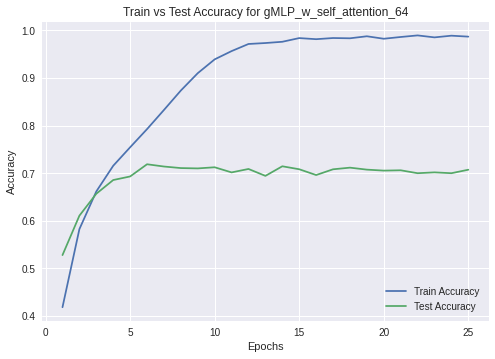

In [41]:
print_performance_graph(epochs, model.name, train_accs, test_accs)

## Results and conclusions

Based on the experiments performed in this notebook, we can see that gMLP achieves superior performance on the CIFAR-10 dataset than ViT which can be further enhanced by add a bit of self attention. The authors work suggests a simpler alternative to the multi-head self-attention layers in Transformers. They
show that gMLPs, a simple variant of MLPs with gating, can be competitive with Transformers in terms of ViT’s accuracy. As demonstrated in the last experiment, blending a small single-head self-attention into gMLP allows for an even better
architecture without the need for increasing model size.